# Post processing and visualizing mandyoc data

The following notebook allows the user to visualize a given mandyoc output (e.g.: `'temperature'`, `'strain_rate'`, `'lithology'`, etc) according to a given number of time instants (e.g.: `instants = [0, 10, 20, 30]` Myr. `len(instants)` must be >= 2.

For a given instant in the `instants` the script will find the closest time step to this instant and plot the respective output.

In [1]:
#increase the display size to 95% of window width
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
display(HTML("<style>.output_result { max-width:95% !important; }</style>"))


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d
import glob
import os
import sys
import pylab as pl
import xarray as xr
import pymp
import mpl_toolkits.axisartist
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import string

path = os.getcwd().split('/')
machine_path = '/'+path[1]+'/'+path[2] #cat the /home/user/ or /Users/user from system using path

sys.path.insert(0, f"{machine_path}/opt/scripts/functions")
from mandyocIO import read_datasets, change_dataset, plot_property, find_nearest, plot_tracked_particles, plot_ptt_paths

# How to plot

## In the following cell, you must inform:
 - The path to your `scenario` without `/OS_home/username` because this is collected by `machine_path`.
     - Ex.: `/mandyoc/experiments/my_experiment/`
 - The mandyoc property `prop` that you want to visualize uncommenting one the commented options.
     - `prop = 'lithology'` is the default.
 - The values in list `instants` containing the instants that you want to visualize.
     - Ex: `instants = [0, 10, 20, 30]` #Myr

In [4]:
v = 1
# v = 2
print(f"Plot models with velocity {v} cm/yr")

#Set scenario path
local = False
if(local==True):
    model_path = machine_path
else:
    external_media = 'Joao_Macedo'
    model_path = f"/Volumes/{external_media}"


if(v==1):
    scenarios = [
                f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lit120km/DT230_Tp1350oC/v1/RFT_DT230_Tp1350oC_v1_Clc1_checkered_false",
                f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lit120km/DT230_Tp1350oC/v1/RFT_DT230_Tp1350oC_v1_Clc10_checkered_false",
                f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lithoramp/DT230_Tp1350oC/v1/RFT_lithoramp_DT230_Tp1350oC_v1_Clc1_checkered_false",
                f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lithoramp/DT230_Tp1350oC/v1/RFT_lithoramp_DT230_Tp1350oC_v1_Clc10_checkered_false",
                ]
elif(v==2):
    scenarios = [
                f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lit120km/DT230_Tp1350oC/v2/RFT_DT230_Tp1350oC_v2_Clc1_checkered_false",
                f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lit120km/DT230_Tp1350oC/v2/RFT_DT230_Tp1350oC_v2_Clc10_checkered_false",
                f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lithoramp/DT230_Tp1350oC/v2/RFT_lithoramp_DT230_Tp1350oC_v2_Clc1_checkered_false",
                f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lithoramp/DT230_Tp1350oC/v2/RFT_lithoramp_DT230_Tp1350oC_v2_Clc10_checkered_false",
                ]

read_ascii = True # if False, it will skip the ascii reading and saving processes and it will read the datasets from previous runs
save_images = True # Generate and save all the possible images
save_big_dataset = False#True
plot_isotherms = True
# plot_melt = True
plot_melt = False

if(plot_isotherms or plot_melt):
    clean_plot=False
else:
    clean_plot = True

datasets = [#Properties from mandyoc. Comment/uncomment to select properties of the dataset
            'density',
            'radiogenic_heat',
            'pressure',
            'strain',
            'strain_rate',### Read ascii outputs and save them as xarray.Datasets,
            'surface',
            'temperature',
            'viscosity'
            ]# Read data and convert them to xarray.Dataset

properties = [#Properties from mandyoc. Comment/uncomment to select which ones you would like to plot
            #  'density',
#              'radiogenic_heat',
             'lithology',
#              'pressure',
            #  'strain',
             'strain_rate',
            #  'temperature',
            #  'temperature_anomaly',
            #  'surface',
            #  'viscosity'
             ]

# Read ascii outputs and save them as xarray.Datasets

new_datasets = change_dataset(properties, datasets)

to_remove = []
remove_density=False
if ('density' not in properties): #used to plot air/curst interface
        properties.append('density')
        new_datasets = change_dataset(properties, datasets)
        to_remove.append('density')
        # remove_density=True

if ('surface' not in properties): #used to plot air/curst interface
        properties.append('surface')
        new_datasets = change_dataset(properties, datasets)
        to_remove.append('surface')
        # remove_density=True

if (plot_isotherms): #add datasets needed to plot isotherms
    if ('temperature' not in new_datasets):
        properties.append('temperature')
        new_datasets = change_dataset(properties, datasets)
        to_remove.append('temperature')

# print(f"newdataset4 {new_datasets}")

if (plot_melt): #add datasets needed to plot melt fraction
    if ('pressure' not in new_datasets):
        properties.append('pressure')
    if ('temperature' not in new_datasets):
        properties.append('temperature')
    new_datasets = change_dataset(properties, datasets)

    #removing the auxiliary datasets to not plot
    to_remove.append('pressure')
    to_remove.append('temperature')

if(clean_plot): #a clean plot
    new_datasets = change_dataset(properties, datasets)

for item in to_remove:
    properties.remove(item)

dataset0 = read_datasets(scenarios[0], new_datasets)
dataset1 = read_datasets(scenarios[1], new_datasets)
dataset2 = read_datasets(scenarios[2], new_datasets)
dataset3 = read_datasets(scenarios[3], new_datasets)

# Normalize velocity values
if ("velocity_x" and "velocity_z") in dataset0.data_vars:
    v_max = np.max((dataset0.velocity_x**2 + dataset0.velocity_z**2)**(0.5))    
    dataset0.velocity_x[:] = dataset0.velocity_x[:] / v_max
    dataset0.velocity_z[:] = dataset0.velocity_z[:] / v_max

if ("velocity_x" and "velocity_z") in dataset1.data_vars:
    v_max = np.max((dataset1.velocity_x**2 + dataset1.velocity_z**2)**(0.5))    
    dataset1.velocity_x[:] = dataset1.velocity_x[:] / v_max
    dataset1.velocity_z[:] = dataset1.velocity_z[:] / v_max

if ("velocity_x" and "velocity_z") in dataset2.data_vars:
    v_max = np.max((dataset2.velocity_x**2 + dataset2.velocity_z**2)**(0.5))    
    dataset2.velocity_x[:] = dataset2.velocity_x[:] / v_max
    dataset2.velocity_z[:] = dataset2.velocity_z[:] / v_max


Nx = int(dataset0.nx)
Nz = int(dataset0.nz)
Lx = float(dataset0.lx)
Lz = float(dataset0.lz)

x = np.linspace(0, Lx/1000.0, Nx)
z = np.linspace(Lz/1000.0, 0, Nz)
xx, zz  = np.meshgrid(x, z)

print(f"\n{dataset0.info}")

trackdataset0 = xr.open_dataset(f"{scenarios[0]}/_track_xzPT_all_steps.nc")
trackdataset1 = xr.open_dataset(f"{scenarios[1]}/_track_xzPT_all_steps.nc")
trackdataset2 = xr.open_dataset(f"{scenarios[2]}/_track_xzPT_all_steps.nc")
trackdataset3 = xr.open_dataset(f"{scenarios[3]}/_track_xzPT_all_steps.nc")

Plot models with velocity 1 cm/yr

<bound method Dataset.info of <xarray.Dataset> Size: 840MB
Dimensions:      (x: 1001, z: 301, time: 87)
Coordinates:
  * x            (x) float64 8kB 0.0 1e+03 2e+03 ... 9.98e+05 9.99e+05 1e+06
  * z            (z) float64 2kB -3e+05 -2.99e+05 -2.98e+05 ... -1e+03 0.0
  * time         (time) float64 696B 0.0 0.5 1.0 1.5 ... 38.59 39.08 39.52 39.93
    step         (time) int32 348B 0 100 200 300 400 ... 8300 8400 8500 8600
Data variables:
    strain       (time, x, z) float64 210MB ...
    density      (time, x, z) float64 210MB ...
    strain_rate  (time, x, z) float64 210MB ...
    surface      (time, x) float64 697kB ...
    temperature  (time, x, z) float64 210MB ...
Attributes: (12/95)
    nx:                                1001
    nz:                                301
    lx:                                1000000.0
    lz:                                300000.0
    multigrid:                         1
    solver:                            d

[300, 900] [-130, 40]
RHvsRT_v1_comparison_with_PTt_lithology


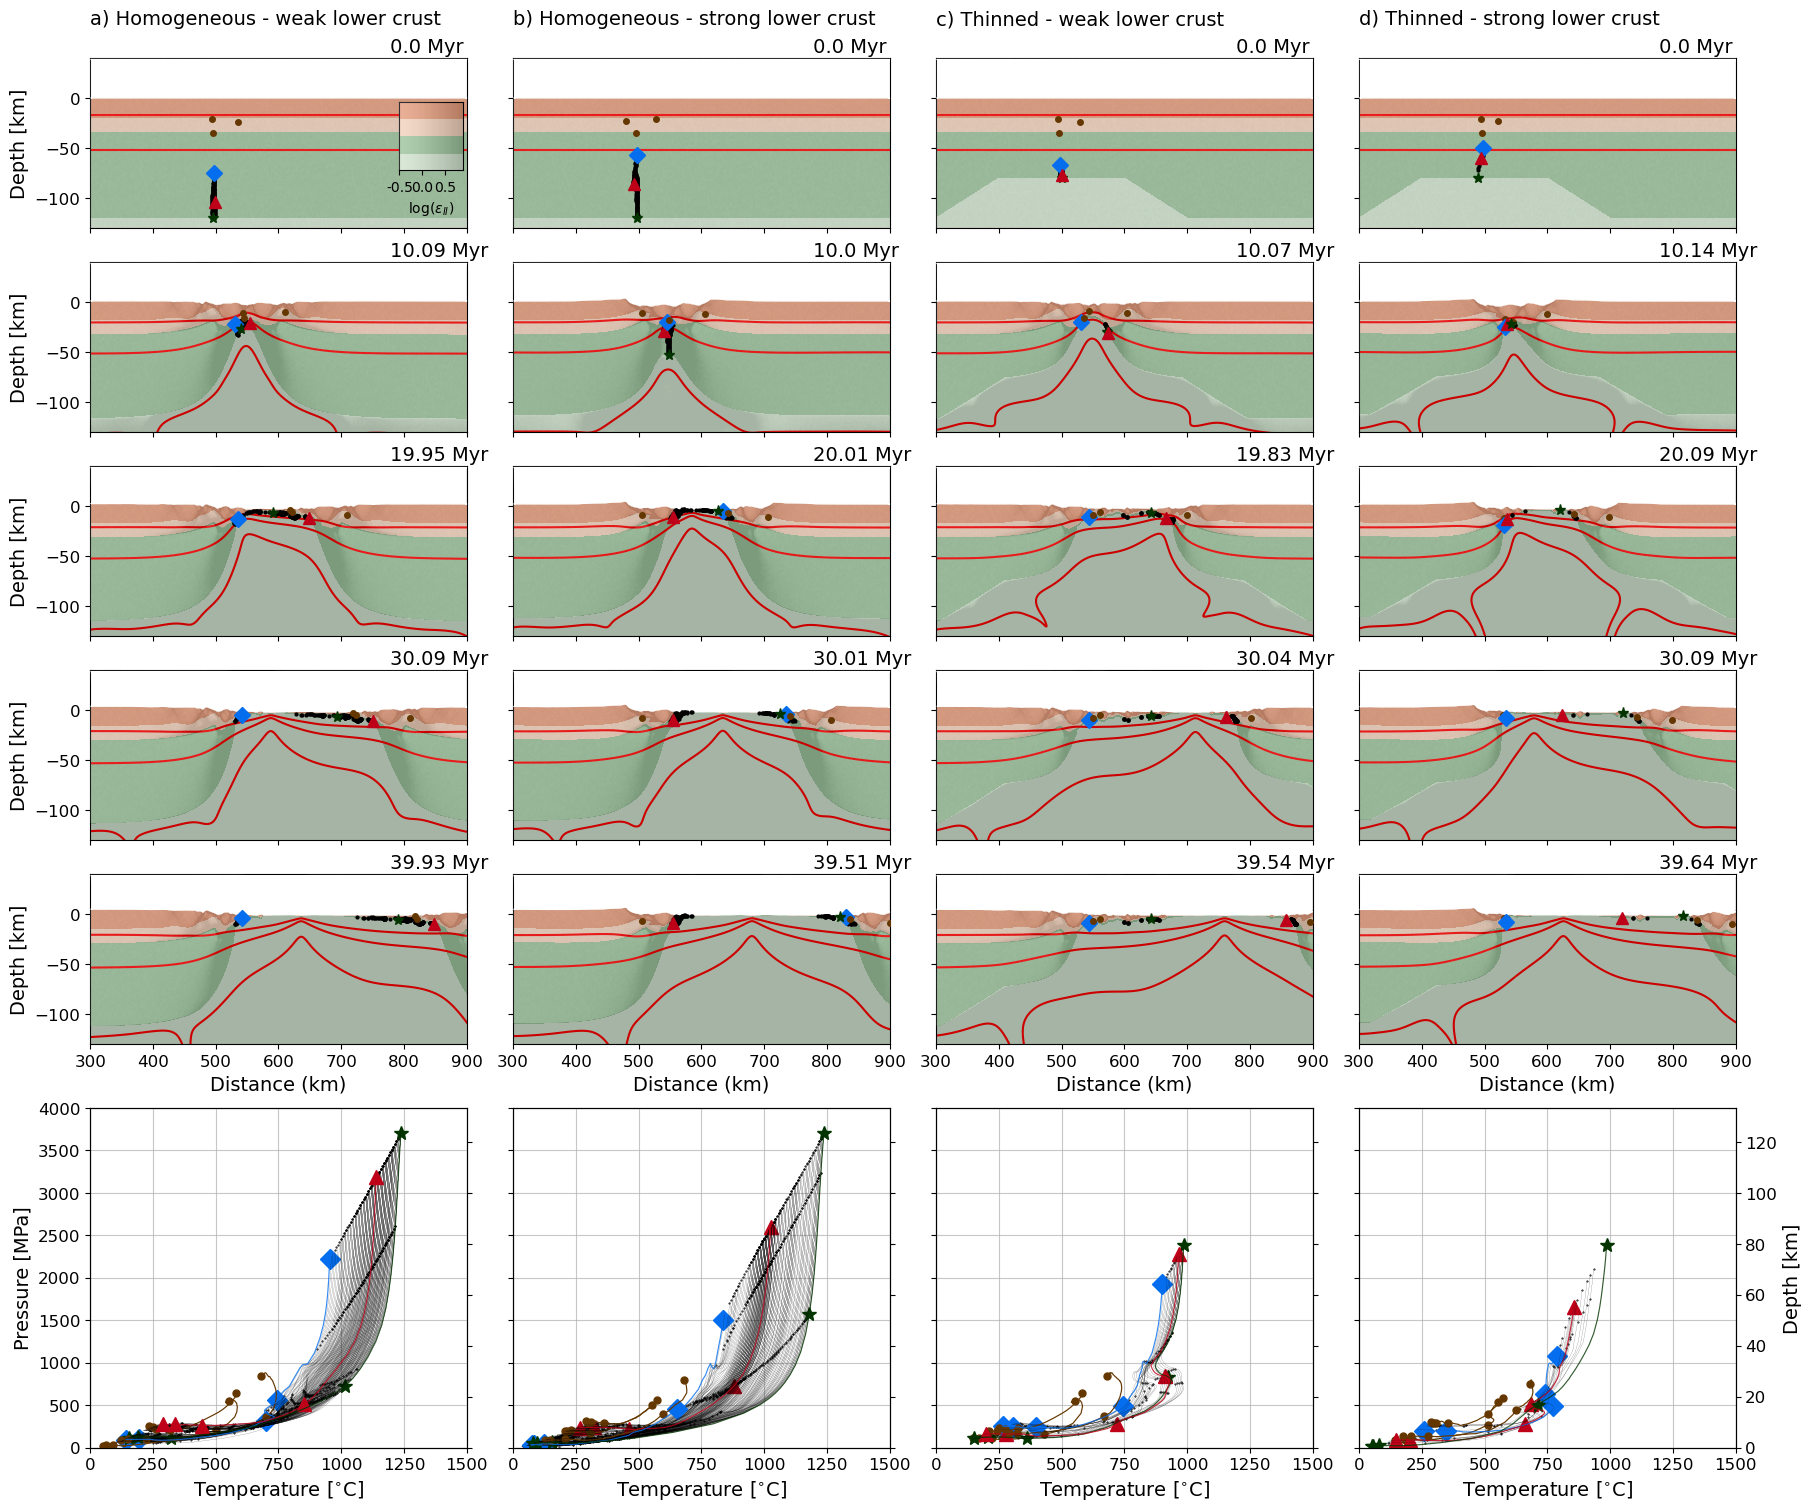

In [7]:
##############################################################################################################
#Set mandyoc property

# prop = 'density'
# prop = 'heat'
prop = 'lithology'
# prop = 'pressure'
# prop = 'strain'
# prop = 'strain_rate'
# prop = 'temperature'
# prop = 'temperature_anomaly'
# prop = 'viscosity'
# prop = 'surface'


if(v==1):
    instants = [0, 10, 20, 30, 40] #Myr
if(v==2):
    instants = [0, 5., 10., 15., 20.] #Myr

plt.close('all')

fig_height = (3.0/2.0)*(len(instants) + 5) #6 minimum
fig = plt.figure(figsize=(18, fig_height), constrained_layout=True)

mosaic = """
         ABCD
         EFGH
         IJKL
         MNOP
         QRST
         UVWX
         """
axs = fig.subplot_mosaic(mosaic, gridspec_kw={'height_ratios':[0.5,
                                                               0.5,
                                                               0.5,
                                                               0.5,
                                                               0.5,
                                                               1.0
                                                              ]
                                             }
                        )

alphabet = list(string.ascii_uppercase)
idxs = np.asarray(alphabet[0: len(instants)*len(scenarios)]) #starting at A subplot
idxs_aux = idxs.reshape(len(instants), len(scenarios))

i = 0
# zoom_uc = True
zoom_uc = False

Lcraton = 1200.0

if(prop != 'surface'): # you can customize
    if(zoom_uc):
        xlims = [float(dataset0.isel(time=i).lx)/2.0e3 - Lcraton/2 - 50, float(dataset0.isel(time=i).lx)/2.0e3 + Lcraton/2 + 50]
        ylims = [-40, 10]
        # plot steps
        plot_particles = True
    else:
        # xlims = [0, float(dataset0.isel(time=i).lx) / 1.0e3]
        # ylims = [-float(dataset0.isel(time=i).lz) / 1.0e3 + 40, 40]
        xlims = [300, 900]
        ylims = [-130, 40]
        # plot steps
        plot_particles = False
        print(xlims, ylims)
else: #for surface plot
    if(zoom_uc):
        xlims = [float(dataset0.isel(time=i).lx)/2.0e3 - Lcraton/2 - 150, float(dataset0.isel(time=i).lx)/2.0e3 + Lcraton/2 + 150]
        ylims = [-1.0, 1.0]
        
    else:
        xmin = 0 #+ 200
        xmax = float(dataset0.isel(time=i).lx) / 1.0E3 #- 200
        xlims = [xmin, xmax]
        ylims = [-1.5, 1.5]

topo_from_density = True
# topo_from_density = False
plot_other_particles = True
# plot_other_particles = False

for instant, i in zip(instants, range(len(instants))):
    idx0 = find_nearest(dataset0.time, instant)
    idx1 = find_nearest(dataset1.time, instant)
    idx2 = find_nearest(dataset2.time, instant)
    idx3 = find_nearest(dataset3.time, instant)

    if(instant == instants[0]):
        plot_colorbar = True
    else:
        plot_colorbar = False

    plot_property(dataset0.isel(time=idx0), prop, xlims, ylims, scenarios[0],
             fig,
             axs[idxs_aux[i, 0]],
             plot_isotherms = plot_isotherms,
             topo_from_density = topo_from_density,
             plot_particles = plot_particles,
             particle_size = 0.2,
             particle_marker = ".",
             ncores = 20,
            #  step_plot = 4,
             isotherms = [500, 800, 1300],
             plot_colorbar=plot_colorbar,
             bbox_to_anchor=(0.84,#horizontal position respective to parent_bbox or "loc" position
                            0.3,# vertical position
                            0.17,# width
                            0.40),
             # plot_melt = plot_melt,
             # melt_method = melt_method,
            )
    plot_tracked_particles(trackdataset0, axs[idxs_aux[i, 0]], idx0, plot_other_particles=plot_other_particles, color_other_particles='xkcd:black', size_other_particles=4)
    
    plot_property(dataset1.isel(time=idx1), prop, xlims, ylims, scenarios[1],
             fig,
             axs[idxs_aux[i, 1]],
             plot_isotherms = plot_isotherms,
             topo_from_density = topo_from_density,
             plot_particles = plot_particles,
             particle_size = 0.2,
             particle_marker = ".",
             ncores = 20,
            #  step_plot = 4,
             isotherms = [500, 800, 1300],
             plot_colorbar=False,
             
             # plot_melt = plot_melt,
             # melt_method = melt_method,
            )
    plot_tracked_particles(trackdataset1, axs[idxs_aux[i, 1]], idx1, plot_other_particles=plot_other_particles, color_other_particles='xkcd:black', size_other_particles=4)

    plot_property(dataset2.isel(time=idx2), prop, xlims, ylims, scenarios[2],
             fig,
             axs[idxs_aux[i, 2]],
             plot_isotherms = plot_isotherms,
             topo_from_density = topo_from_density,
             plot_particles = plot_particles,
             particle_size = 0.2,
             particle_marker = ".",
             ncores = 20,
            #  step_plot = 4,
             isotherms = [500, 800, 1300],
             plot_colorbar=False,
             
             # plot_melt = plot_melt,
             # melt_method = melt_method,
            )
    plot_tracked_particles(trackdataset2, axs[idxs_aux[i, 2]], idx2, plot_other_particles=plot_other_particles)

    plot_property(dataset3.isel(time=idx3), prop, xlims, ylims, scenarios[3],
             fig,
             axs[idxs_aux[i, 3]],
             plot_isotherms = plot_isotherms,
             topo_from_density = topo_from_density,
             plot_particles = plot_particles,
             particle_size = 0.2,
             particle_marker = ".",
             ncores = 20,
            #  step_plot = 4,
             isotherms = [500, 800, 1300],
             plot_colorbar=False,
             
             # plot_melt = plot_melt,
             # melt_method = melt_method,
            )
    plot_tracked_particles(trackdataset3, axs[idxs_aux[i, 3]], idx3, plot_other_particles=plot_other_particles, color_other_particles='xkcd:black', size_other_particles=4)


# plot_ptt_paths(trackdataset0, axs['Q'], instants)
# plot_ptt_paths(trackdataset1, axs['R'], instants)
# plot_ptt_paths(trackdataset2, axs['S'], instants)
# plot_ptt_paths(trackdataset3, axs['T'], instants)

color_other_particles='xkcd:black'
size_other_particles=0.9

idxs_ptts = np.asarray(alphabet[len(instants)*len(scenarios): len(instants)*len(scenarios)+len(scenarios)])
plot_ptt_paths(trackdataset0, axs[idxs_ptts[0]], instants, plot_other_particles=plot_other_particles, color_other_particles=color_other_particles, size_other_particles=size_other_particles)
plot_ptt_paths(trackdataset1, axs[idxs_ptts[1]], instants, plot_other_particles=plot_other_particles, color_other_particles=color_other_particles, size_other_particles=size_other_particles)
plot_ptt_paths(trackdataset2, axs[idxs_ptts[2]], instants, plot_other_particles=plot_other_particles, color_other_particles=color_other_particles, size_other_particles=size_other_particles)
plot_ptt_paths(trackdataset3, axs[idxs_ptts[3]], instants, plot_other_particles=plot_other_particles, color_other_particles=color_other_particles, size_other_particles=size_other_particles)

fsize = 14

# axs[1].yaxis.set_label_position("right")
# axs[1].tick_params(axis='y', labelright=True, labelleft=False, labelsize=fsize)

ylims = np.array([0, 4000])

axs[idxs_ptts[0]].set_ylabel('Pressure [MPa]', fontsize=fsize)
# for letter in ['Q', 'R', 'S', 'T']:
# for letter in ['U', 'V', 'W', 'X']:
for letter in list(idxs_ptts):
    axs[letter].tick_params(axis='both', labelsize=fsize-2)
    axs[letter].grid('-k', alpha=0.7)
    axs[letter].set_xlabel(r'Temperature [$^{\circ}$C]', fontsize=fsize)
    axs[letter].set_xlim([0, 1500])
    axs[letter].set_ylim(ylims)
    if letter != idxs_ptts[0]:
    # if letter != idxs_ptts[0]:
        axs[letter].set_yticklabels([])

    #creating depth axis to PTt plot
    ax1 = axs[letter].twinx()
    ax1.set_ylim(ylims/30)
    # ax1.tick_params(axis='y', labelright=False, labelleft=True, labelsize=fsize)
    ax1.tick_params(axis='y', labelsize=fsize-2)
    ax1.set_ylabel('Depth [km]', fontsize=fsize) if letter == idxs_ptts[-1] else ax1.set_yticklabels([])
        

##########################
#Set plot details
##########################
#Titles
# axs['A'].set_title(r'Reference Scenario')
axs['A'].text(0.0, 1.2, f"a) Homogeneous - weak lower crust", transform=axs['A'].transAxes, fontsize=14)

# axs['B'].set_title(r'Shifted Cratonic Keel')
axs['B'].text(0.0, 1.2, f"b) Homogeneous - strong lower crust", transform=axs['B'].transAxes, fontsize=14)

# axs['C'].set_title(r'Constant Asthenospheric Drag')
axs['C'].text(0.0, 1.2, f"c) Thinned - weak lower crust", transform=axs['C'].transAxes, fontsize=14)

# axs['D'].set_title(r'Alternating Asthenospheric Drag')
axs['D'].text(0.0, 1.2, f"d) Thinned - strong lower crust", transform=axs['D'].transAxes, fontsize=14)

line_labels = np.asarray(list(string.ascii_lowercase)[0: 4])
label_fsize = 14
for i in range(len(instants)):
    ax_name = idxs_aux[i, 2]
    axs[idxs_aux[i, 0]].set_ylabel('Depth [km]', fontsize=label_fsize)
    axs[idxs_aux[i, 1]].set_yticklabels([])
    axs[idxs_aux[i, 2]].set_yticklabels([])
    axs[idxs_aux[i, 3]].set_yticklabels([])

    # axs[idxs_aux[i, 0]].text(-0.1, 0.95, f"{line_labels[i]})", transform=axs[idxs_aux[i, 0]].transAxes, fontsize=16)

    if(i == len(instants) - 1):
        axs[idxs_aux[i, 0]].set_xlabel('Distance (km)', fontsize=label_fsize)
        axs[idxs_aux[i, 1]].set_xlabel('Distance (km)', fontsize=label_fsize)
        axs[idxs_aux[i, 2]].set_xlabel('Distance (km)', fontsize=label_fsize)
        axs[idxs_aux[i, 3]].set_xlabel('Distance (km)', fontsize=label_fsize)
        
    else:
        axs[idxs_aux[i, 0]].set_xticklabels([])
        axs[idxs_aux[i, 1]].set_xticklabels([])
        axs[idxs_aux[i, 2]].set_xticklabels([])
        axs[idxs_aux[i, 3]].set_xticklabels([])

figname = f"RHvsRT_v{v}_comparison_with_PTt_{prop}"

print(figname)
fig.savefig(f"figures/{figname}.png", dpi=200)
fig.savefig(f"figures/{figname}.pdf", dpi=200)

In [21]:
idxs_ptts

array(['U', 'V', 'W', 'X'], dtype='<U1')